Train a basic logistic regression with TF-IDF.
Compare TF-IDF vs Style features vs Combination vs Class balance.
Tune hyperparameters (if needed)  

In the first part of the code we would test LR + TF and class balance. Next, we will test style features but on balanced class. And then, we would test LR + TF-IDF (1–2 grams) + Style Features stacked

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.utils import load_cleaned_data, split, metrics

# Setup for the model

In [102]:
df = load_cleaned_data("data/byarticle_clean.tsv")
X = df["full_text"]
y = df["label"]
X_train, X_test, y_train, y_test = split(X, y)

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
vec.fit(df['full_text'])
print(f"Total unique words in dataset: {len(vec.vocabulary_)}")


Total unique words in dataset: 21951


# TF-IDF Vectorization

Just checking how many unique words we have in the by-article dataset.

Try TF-IDF with:

    max_features=5000

    max_features=10000 (precision almost same, increase in recall)

    max_features=20000 (no diff. with 10000)

Using both unigrams and bigrams as features. In by-article case, ngrams do not much of a difference.

In [104]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic regression + TF vs LR+TF+class balanced

max_iter=1000 (def. 100): This sets the maximum number of training iterations.

'liblinear' is good for small/medium datasets and works well for binary classification, like in our case (hyperpartisan = 1 or 0).

testing with balancing.

In [105]:
clf = LogisticRegression(class_weight='balanced',max_iter=1000, solver='liblinear')
clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

# Evaluation

Accuracy: 0.78
Precision: 0.66
Recall: 0.81
F1: 0.73


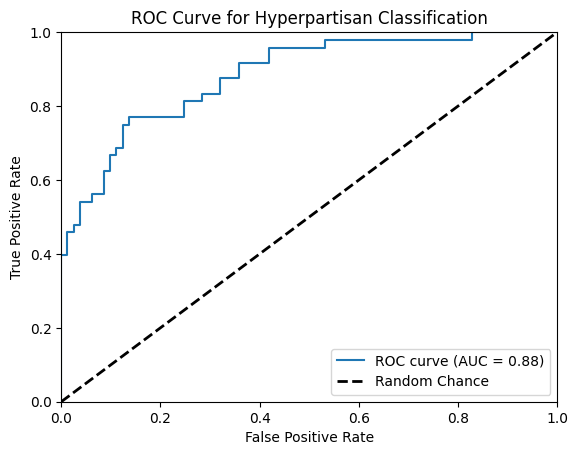

In [106]:
y_pred = clf.predict(X_test_tfidf)
y_proba = clf.predict_proba(X_test_tfidf)[:, 1]
metrics(y_test, y_pred, y_proba)

# Analyze

Testing with LR + TF:
Accuracy: 0.79 -> not very reliable for main metric, could be misleading due to imbalance
Precision: 0.82 -> quite high.
Recall: 0.56 -> quite low, misisng many real hyperpartisan articles.
F1: 0.67

Should focus on recall and precision.

Testing LR + TF + class balance: Recall increase is a big deal: the model now correctly finds many more hyperpartisan articles. 0.56 -> 0.81
Precision drop is expected — model is more generous in labeling as hyperpartisan, but many are still correct. 0.82 -> 0.66
AUC unchanged means the model is ranking correctly — it can still differentiate strong vs weak hyperpartisan signals.
F1 probably improved: now closer to a balance between precision and recall.



# Trying with style features + balanced (ONLY)

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [108]:
style_features = ['uppercase_ratio', 'exclamation_count', 'avg_sentence_length']
X = df[style_features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)


Scaling of the style features. Since exclamation_count and avg_sentece_length have different scale.

In [109]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training LR + class balancing

In [110]:
clf = LogisticRegression(class_weight='balanced', random_state=0)
clf.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

Evaluate the model

In [111]:
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        81
           1       0.47      0.65      0.54        48

    accuracy                           0.60       129
   macro avg       0.60      0.61      0.59       129
weighted avg       0.63      0.60      0.60       129

AUC: 0.6540637860082306


# Analyze

Recall is higher than precision → the model finds many hyperpartisan articles (good), but also has false positives.

AUC of 0.65 → better than random (0.5), but not strong enough alone.

Style features do contribute, but likely not sufficient on their own.

# Next Step: Logistic Regression + TF-IDF + Style + Class Balance

In [112]:
from scipy.sparse import hstack

In [113]:
text_data = df['full_text']
style_features = df[['uppercase_ratio', 'exclamation_count', 'avg_sentence_length']]
y = df['label']

TF-vectorizer / Scaler / Split

In [114]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_text = vectorizer.fit_transform(text_data)

# Scale style features
scaler = StandardScaler()
X_style = scaler.fit_transform(style_features)

# Combine sparse text + dense style into one
X_combined = hstack([X_text, X_style])

# Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)


In [115]:
# Logistic regression with class balance
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)

In [116]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80        81
           1       0.67      0.65      0.66        48

    accuracy                           0.75       129
   macro avg       0.73      0.73      0.73       129
weighted avg       0.75      0.75      0.75       129

AUC: 0.7813786008230452


# Final analyze

Overall, LR + TF-IDF + Balanced has the best AUC (0.88) and best recall + F1. The style features did not improve it, and in fact, slightly reduced performance.


On noisier data (e.g. by-publisher), style features might help more — worth checking later.